## 可能會有的問題
* max_len 不要設太大
* 要改bert傳入的東西要先讀讀他的source code
* predict, plot還沒寫

## Runtime Environment

* python >= 3.7
* pytorch >= 1.0
* transformers
* pandas
* nltk
* numpy
* sklearn
* pickle
* tqdm
* json

## Set Random seed

In [1]:
import torch
torch.manual_seed(58)

# Take a  view of dataset

In [2]:
import pandas as pd

dataset = pd.read_csv('../data/task2_trainset.csv', dtype=str)
dataset.head()
dataset.tail()

,Id,Title,Abstract,Authors,Categories,Created Date,Task 2
6995,D06996,RUM: network Representation learning throUgh M...,We have witnessed the discovery of many techni...,Yu/Lu/Liu/Zhao/Wen/Zheng,cs.LG/cs.SI,2017-10-08,THEORETICAL ENGINEERING
6996,D06997,Towards Zero-Shot Frame Semantic Parsing for D...,State-of-the-art slot filling models for goal-...,Bapna/Tur/Hakkani-Tur/Heck,cs.AI/cs.CL,2017-07-07,ENGINEERING
6997,D06998,Efficient Dense Modules of Asymmetric Convolut...,Real-time semantic segmentation plays an impor...,Lo/Hang/Chan/Lin,cs.CV,2018-09-17,ENGINEERING
6998,D06999,Network Vector: Distributed Representations of...,We propose a neural embedding algorithm called...,Wu/Lerman,cs.SI/cs.LG,2017-09-07,THEORETICAL EMPIRICAL
6999,D07000,Asymptotic Analysis of Spatial Coupling Coding...,Compute-and-forward (CAF) relaying is effectiv...,Takabe/Wadayama/Hayashi,cs.IT/math.IT,2018-07-03,THEORETICAL


**Id**: 流水號  
**Title**: 論文標題  
**Abstract**: 論文摘要內容, 句子間以 **$$$** 分隔  
**Authors**: 論文作者  
**Categories**: 論文類別  
**Created date**: 論文上傳日期  
**Task 2**: 論文分類類別, 若句子有多個類別,以 **空格** 分隔 

# Data processing

## 刪除多於資訊 (Remove redundant information)  
我們在資料集中保留了許多額外資訊供大家使用，但是在這次的教學中我們並沒有用到全部資訊，因此先將多餘的部分先抽走。  
In dataset, we reserved lots of information. But in this tutorial, we don't need them, so we need to discard them.

In [3]:
dataset.drop('Title',axis=1,inplace=True)
dataset.drop('Categories',axis=1,inplace=True)
dataset.drop('Created Date',axis=1, inplace=True)
dataset.drop('Authors',axis=1,inplace=True)

In [4]:
dataset.head(10)

,Id,Abstract,Task 2
0,D00001,Rapid popularity of Internet of Things (IoT) a...,THEORETICAL
1,D00002,"In this paper, we address the problem of compu...",THEORETICAL
2,D00003,High quality upsampling of sparse 3D point clo...,ENGINEERING
3,D00004,Internet is the main source of information now...,EMPIRICAL
4,D00005,Automated Facial Expression Recognition (FER) ...,ENGINEERING
5,D00006,This paper proposes the continuous semantic to...,THEORETICAL EMPIRICAL
6,D00007,Existing deep multitask learning (MTL) approac...,THEORETICAL EMPIRICAL
7,D00008,In this paper we explore the use of electrical...,ENGINEERING EMPIRICAL
8,D00009,How spiking networks are able to perform proba...,ENGINEERING EMPIRICAL
9,D00010,Low-density parity-check (LDPC) codes on symme...,THEORETICAL


## 資料切割  (Partition)
在訓練時，我們需要有個方法去檢驗訓練結果的好壞，因此需要將訓練資料切成training/validataion set。   
While training, we need some method to exam our model's performance, so we divide our training data into training/validataion set.

In [5]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

trainset, validset = train_test_split(dataset, test_size=0.1, random_state=42)

trainset.to_csv('trainset.csv', index=False)
validset.to_csv('validset.csv', index=False)

### For test data

In [6]:
dataset = pd.read_csv('../data/task2_public_testset.csv', dtype=str)
dataset.drop('Title',axis=1,inplace=True)
dataset.drop('Categories',axis=1,inplace=True)
dataset.drop('Created Date',axis=1, inplace=True)
dataset.drop('Authors',axis=1,inplace=True)
dataset.to_csv('testset.csv',index=False)

### 資料格式化 (Data formatting)  
有了字典後，接下來我們要把資料整理成一筆一筆，把input的句子轉成數字，把答案轉成onehot的形式。  
這裡，我們一樣使用`multiprocessing`來加入進行。  
After building dictionary, that's mapping our sentences into number array, and convert answers to onehot format.  

# BERT

In [7]:
from transformers import BertTokenizer, BertForMaskedLM

PRETRAINED_MODEL_NAME = 'bert-base-uncased'

NUM_LABLES = 4

I1013 00:59:19.835834 140161503090368 file_utils.py:39] PyTorch version 1.2.0 available.
I1013 00:59:19.874181 140161503090368 modeling_xlnet.py:194] Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex .


In [8]:
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL_NAME)

vocab = tokenizer.vocab
print("字典大小：", len(vocab))

I1013 00:59:23.988772 140161503090368 tokenization_utils.py:373] loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /home/student/06/b06902124/.cache/torch/transformers/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084


字典大小： 30522


In [9]:
from tqdm import tqdm_notebook as tqdm
from multiprocessing import Pool

def label_to_onehot(labels):
    """ Convert label to onehot .
        Args:
            labels (string): sentence's labels.
        Return:
            outputs (onehot list): sentence's onehot label.
    """
    label_dict = {'THEORETICAL': 0, 'ENGINEERING':1, 'EMPIRICAL':2, 'OTHERS':3}
    onehot = [0,0,0,0]
    for l in labels.split():
        onehot[label_dict[l]] = 1
    return onehot
        
def sentence_to_indices(sent, tokenizer):
    """ Convert sentence to its word indices.
    Args:
        sentence (str): One string.
    Return:
        indices (list of int): List of word indices.
    """
    return [tokenizer.convert_tokens_to_ids(word) for word in tokenizer.tokenize(sent)]
    
def get_dataset(data_path, tokenizer, n_workers=4):
    """ Load data and return dataset for training and validating.

    Args:
        data_path (str): Path to the data.
    """
    dataset = pd.read_csv(data_path, dtype=str)

    results = [None] * n_workers
    with Pool(processes=n_workers) as pool:
        for i in range(n_workers):
            batch_start = (len(dataset) // n_workers) * i
            if i == n_workers - 1:
                batch_end = len(dataset)
            else:
                batch_end = (len(dataset) // n_workers) * (i + 1)
            
            batch = dataset[batch_start: batch_end]
            results[i] = pool.apply_async(preprocess_samples, args=(batch, tokenizer))

        pool.close()
        pool.join()

    processed = []
    for result in results:
        processed += result.get()
    return processed

def preprocess_samples(dataset, tokenizer):
    """ Worker function.

    Args:
        dataset (list of dict)
    Returns:
        list of processed dict.
    """
    processed = []
    for sample in tqdm(dataset.iterrows(), total=len(dataset)):
        processed.append(preprocess_sample(sample[1], tokenizer))

    return processed

def preprocess_sample(data, tokenizer):
    """
    Args:
        data (dict)
    Returns:
        dict
    """
    processed = {}
    processed['tokens'] = [sentence_to_indices(sent, tokenizer) 
                           for sent in data['Abstract'].split('$$$')]
    processed['tokens'] = sum(processed['tokens'], [])
    processed['tokens'] = [tokenizer.convert_tokens_to_ids('[CLS]')] + processed['tokens'] + [tokenizer.convert_tokens_to_ids('[SEP]')]
    processed['segments'] = [0] * len(processed['tokens'])
    
    if 'Task 2' in data:
        processed['Label'] = label_to_onehot(data['Task 2'])
        
    return processed

In [10]:
print('[INFO] Start processing trainset...')
train = get_dataset('trainset.csv', tokenizer, n_workers=8)
print('[INFO] Start processing validset...')
valid = get_dataset('validset.csv', tokenizer, n_workers=8)
print('[INFO] Start processing testset...')
test = get_dataset('testset.csv', tokenizer, n_workers=8)

[INFO] Start processing trainset...








[INFO] Start processing validset...








[INFO] Start processing testset...










In [11]:
print(train[0])
print(trainset.shape)

{'tokens': [101, 1996, 2001, 8043, 8602, 12046, 2030, 3011, 2693, 2099, 1005, 1055, 3292, 1006, 7861, 2094, 1007, 2003, 1037, 6179, 6994, 1999, 6747, 1010, 3698, 4083, 1998, 3274, 2671, 2007, 2116, 5097, 2000, 6897, 2030, 2966, 12126, 1010, 2426, 2500, 1012, 2926, 1999, 1996, 2422, 1997, 6233, 3375, 2951, 1010, 1996, 22334, 1997, 2122, 12103, 3081, 15502, 3665, 2003, 2411, 1996, 14879, 5387, 1012, 4427, 2011, 2023, 4119, 1010, 1037, 3528, 1997, 2047, 8107, 2000, 15502, 3665, 2038, 2042, 3818, 1999, 3522, 2086, 1998, 2247, 2007, 2122, 2047, 4725, 3310, 1996, 2342, 2005, 1037, 15902, 7831, 1012, 1999, 2023, 3259, 1010, 2057, 8970, 1037, 6847, 10665, 2005, 16246, 15502, 3665, 1010, 2170, 11089, 10665, 1010, 2029, 2003, 2881, 2000, 3710, 2004, 1037, 8699, 3074, 1997, 3471, 1010, 2073, 16246, 15502, 3665, 4725, 2064, 2022, 7718, 1010, 4102, 2000, 2028, 2178, 1010, 1998, 2716, 2000, 2037, 6537, 2006, 2312, 1011, 4094, 12107, 1012, 2009, 3774, 1997, 1037, 3528, 1997, 3897, 15782, 2571, 4871, 

In [12]:
# max_len sentence
#m = 0
cnt_castrated_case = 0
for t in test:
    if len(t['tokens']) > 512:
        #m = len(t['tokens'])
        cnt_castrated_case += 1
print(cnt_castrated_case)

4


## 資料封裝 (Data packing)

為了更方便的進行batch training，我們將會借助[torch.utils.data.DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)。  
而要將資料放入dataloader，我們需要繼承[torch.utils.data.Dataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset)，撰寫適合這份dataset的class。  
`collate_fn`用於batch data的後處理，在`dataloder`將選出的data放進list後會呼叫collate_fn，而我們會在此把sentence padding到同樣的長度，才能夠放入torch tensor (tensor必須為矩陣)。  

To easily training in batch, we'll use `dataloader`, which is a function built in Pytorch[torch.utils.data.DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)  
To use datalaoder, we need to packing our data into class `dataset` [torch.utils.data.Dataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset)  
`collate_fn` is used for data processing.

In [13]:
from torch.utils.data import Dataset
import torch

class BertDataset(Dataset):
    def __init__(self, data, max_len = 512):
        self.data = data
        self.max_len = max_len
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index]
        
    def collate_fn(self, datas):
        # get max length in this batch
        max_len = max([min(len(data['tokens']), self.max_len) for data in datas])
        batch_tokens = []
        batch_segments = []
        batch_masks = []
        batch_label = []
        for data in datas:
            # padding abstract to make them in same length
            abstract_len = len(data['tokens'])
            if abstract_len > max_len:
                batch_tokens.append(data['tokens'][:max_len])
                batch_segments.append(data['segments'][:max_len])
                batch_masks.append([1] * max_len)
            else:
                batch_tokens.append(data['tokens'] + [0] * (max_len-abstract_len))
                batch_segments.append(data['segments'] + [0] * (max_len-abstract_len))
                batch_masks.append([1] * abstract_len  + [0] * (max_len-abstract_len))
            # gather labels
            if 'Label' in data:
                batch_label.append(data['Label'])
        return torch.LongTensor(batch_tokens), torch.LongTensor(batch_segments), torch.LongTensor(batch_masks), torch.FloatTensor(batch_label)

In [14]:
trainData = BertDataset(train)
validData = BertDataset(valid)
testData = BertDataset(test)

# model

In [15]:
from transformers import BertModel, BertPreTrainedModel

In [16]:
class BertForMultiLabelSequenceClassification(BertPreTrainedModel):
    """BERT model for classification.
    This module is composed of the BERT model with a linear layer on top of
    the pooled output.
    """
    def __init__(self, config):
        super(BertForMultiLabelSequenceClassification, self).__init__(config)
        
        self.bert = BertModel(config)
        self.dropout = torch.nn.Dropout(config.hidden_dropout_prob)
        self.classifier = torch.nn.Linear(config.hidden_size + 24, config.num_labels)
        
        self.init_weights()

    def forward(self, input_ids, node_vec, token_type_ids=None, attention_mask=None, 
                position_ids=None, head_mask=None, labels=None):
        
        outputs = self.bert(input_ids, 
                            token_type_ids = token_type_ids, 
                            attention_mask = attention_mask, 
                            position_ids=None, head_mask=None)
        
        outputs = self.dropout(outputs[1])
        #print('drop: ', outputs.shape, 'node: ', node_vec.shape)
        #print(outputs.shape)
        logits = self.classifier(torch.cat((outputs, node_vec), 1))
        
        #outputs = (logits,) + outputs[1:]
        
        return logits#outputs[0]
        
    def freeze_bert_encoder(self):
        for param in self.bert.parameters():
            param.requires_grad = False
    
    def unfreeze_bert_encoder(self):
        for param in self.bert.parameters():
            param.requires_grad = True

In [17]:
model = BertForMultiLabelSequenceClassification.from_pretrained(PRETRAINED_MODEL_NAME, num_labels = 4)
# model.freeze_bert_encoder()

I1013 00:59:55.676883 140161503090368 configuration_utils.py:151] loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json from cache at /home/student/06/b06902124/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.bf3b9ea126d8c0001ee8a1e8b92229871d06d36d8808208cc2449280da87785c
I1013 00:59:55.680915 140161503090368 configuration_utils.py:168] Model config {
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 4,
  "output_attentions": false,
  "output_hidden_states": false,
  "pruned_heads": {},
  "torchscript": false,
  "type_vocab_size": 2,
  "use_bfloat16": false,
  "vocab_size": 30522
}

I1013 00:59:56.620226 140161

In [18]:
print(model)

BertForMultiLabelSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-1

# Train

指定使用的運算裝置  
Designate running device.

In [19]:
#%env CUDA_VISIBLE_DEVICES=1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

定義一個算分公式, 讓我們在training能快速了解model的效能
Define score function, let us easily observe model performance while training.

In [20]:
class F1():
    def __init__(self):
        self.threshold = 0.0
        self.n_precision = 0
        self.n_recall = 0
        self.n_corrects = 0
        self.name = 'F1'

    def reset(self):
        self.n_precision = 0
        self.n_recall = 0
        self.n_corrects = 0

    def update(self, predicts, groundTruth):
        predicts = predicts > self.threshold
        self.n_precision += torch.sum(predicts).data.item()
        self.n_recall += torch.sum(groundTruth).data.item()
        self.n_corrects += torch.sum(groundTruth.type(torch.bool) * predicts).data.item()

    def get_score(self):
        recall = self.n_corrects / self.n_recall
        precision = self.n_corrects / (self.n_precision + 1e-20)
        return 2 * (recall * precision) / (recall + precision + 1e-20)

    def print_score(self):
        score = self.get_score()
        return '{:.5f}'.format(score)


## 定義參數

In [21]:
BATCH_SIZE = 2
EPOCHS = 6

In [22]:
import os
import pickle


################################
# for embedding graph features #
################################

with open('node_vec.pkl', 'rb') as file:
    node_tensor = pickle.load(file)
#node_tensor = torch.cat((node_tensor, torch.zeros((1, 24)).type(torch.DoubleTensor)), 0)
print(node_tensor.shape)

train_nodevec, valid_nodevec = node_tensor[:6300], node_tensor[6300:]


sample_size = train_nodevec.shape[0]
node_trainset = []
for i in range(sample_size//BATCH_SIZE):
    _tmp = train_nodevec[i*2:i*2+2]
    node_trainset.append(_tmp)
print('length of training node vector pack: ', len(node_trainset))

sample_size = valid_nodevec.shape[0]
node_validset = []
for i in range(sample_size//BATCH_SIZE):
    _tmp = valid_nodevec[i*2:i*2+2]
    node_validset.append(_tmp)
print('length of validation node vector pack: ', len(node_validset))

################################


    
def _run_epoch(epoch, training):
    model.train(training)
    if training:
        description = 'Train'
        BATCH_SIZE = 2
        dataset = trainData
        shuffle = True
        node_vec = node_trainset
    else:
        description = 'Valid'
        BATCH_SIZE = 2
        dataset = validData
        shuffle = False
        node_vec = node_validset
    
    dataloader = DataLoader(dataset=dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=shuffle,
                            collate_fn=dataset.collate_fn,
                            num_workers=4)
    
    trange = tqdm(enumerate(dataloader), total=len(dataloader), desc=description)
    loss = 0.0
    f1_score = F1()
    for i, (tokens, segments, masks, labels) in trange:
        o_labels, batch_loss = _run_iter(tokens, segments, masks, labels, node_vec=node_vec[i].type(torch.FloatTensor))
        
        if training:
            opt.zero_grad()
            batch_loss.backward()
            opt.step()
        
        
        loss += batch_loss.item()
        f1_score.update(o_labels.cpu(), labels)
        
        trange.set_postfix(
            loss=loss / (i + 1), f1=f1_score.print_score())
        
    
    if training:
        history['train'].append({'f1':f1_score.get_score(), 'loss':loss/ len(trange)})
    else:
        history['valid'].append({'f1':f1_score.get_score(), 'loss':loss/ len(trange)})

        
def _run_iter(tokens, segments, masks, labels, node_vec=torch.zeros(BATCH_SIZE, 0)):
    tokens = tokens.to(device)
    segments = segments.to(device)
    masks = masks.to(device)
    labels = labels.to(device)
    node_vec = node_vec.to(device)
    outputs = model(tokens, node_vec=node_vec, token_type_ids=segments, attention_mask=masks)
    l_loss = criteria(outputs, labels)
    return outputs, l_loss

def save(epoch):
    if not os.path.exists('model'):
        os.makedirs('model')
    torch.save(model.state_dict(), 'model/model-1.pkl.'+str(epoch))
    with open('model/history-1.json', 'w') as f:
        json.dump(history, f, indent=4)

torch.Size([7000, 24])


In [23]:
from torch.utils.data import DataLoader
from tqdm import trange
import json

opt = torch.optim.AdamW(model.parameters(), lr=1e-5, eps = 1e-8)
criteria = torch.nn.BCEWithLogitsLoss()

model.to(device)
history = {'train':[],'valid':[]}

In [24]:
for epoch in range(EPOCHS):
    print('Epoch: {}'.format(epoch))
    if epoch > 1:
        model.freeze_bert_encoder()
    _run_epoch(epoch, True)
    _run_epoch(epoch, False)
    save(epoch)

Epoch: 0



Epoch: 1



Epoch: 2



Epoch: 3



Epoch: 4



Epoch: 5


# Plot

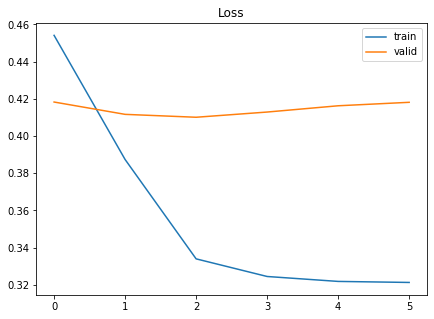

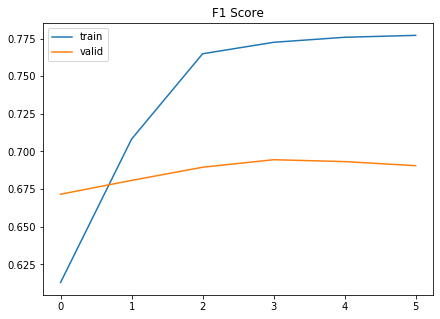

Best F1 score  [0.6944927536231884, 3]


In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

with open('model/history-1.json', 'r') as f:
    history = json.loads(f.read())

train_loss = [l['loss'] for l in history['train']]
valid_loss = [l['loss'] for l in history['valid']]
train_f1 = [l['f1'] for l in history['train']]
valid_f1 = [l['f1'] for l in history['valid']]

plt.figure(figsize=(7,5))
plt.title('Loss')
plt.plot(train_loss, label='train')
plt.plot(valid_loss, label='valid')
plt.legend()
plt.show()

plt.figure(figsize=(7,5))
plt.title('F1 Score')
plt.plot(train_f1, label='train')
plt.plot(valid_f1, label='valid')
plt.legend()
plt.show()

print('Best F1 score ', max([[l['f1'], idx] for idx, l in enumerate(history['valid'])]))

# Prediction

In [ ]:
model.load_state_dict(torch.load('model/model-1.pkl.{}'.format(0)))
model.train(False)
# _run_epoch(1, False)
dataloader = DataLoader(dataset=testData,
                            batch_size=16,
                            shuffle=False,
                            collate_fn=testData.collate_fn,
                            num_workers=4)
trange = tqdm(enumerate(dataloader), total=len(dataloader), desc='Predict')
prediction = []
for i, (tokens, segments, masks, labels) in trange:
    with torch.no_grad():
        o_labels = model(tokens.to(device), segments.to(device), masks.to(device))
        o_labels = o_labels>0.0
        prediction.append(o_labels.to('cpu'))

print(prediction)

#prediction = torch.cat(prediction).detach().numpy().astype(int)

In [ ]:
a = list(prediction)
for i in a: 
    if i[3] == 1:
        if not (i[0]==0 and i[1]==0 and i[2]==0):
            #print(i)
            pass
print(prediction)

In [ ]:
def SubmitGenerator(prediction, sampleFile, public=True, filename='prediction-1.csv'):
    """
    Args:
        prediction (numpy array)
        sampleFile (str)
        public (boolean)
        filename (str)
    """
    sample = pd.read_csv(sampleFile)
    submit = {}
    submit['order_id'] = list(sample.order_id.values)
    redundant = len(sample) - prediction.shape[0]
    if public:
        submit['THEORETICAL'] = list(prediction[:,0]) + [0]*redundant
        submit['ENGINEERING'] = list(prediction[:,1]) + [0]*redundant
        submit['EMPIRICAL'] = list(prediction[:,2]) + [0]*redundant
        submit['OTHERS'] = list(prediction[:,3]) + [0]*redundant
    else:
        submit['THEORETICAL'] = [0]*redundant + list(prediction[:,0])
        submit['ENGINEERING'] = [0]*redundant + list(prediction[:,1])
        submit['EMPIRICAL'] = [0]*redundant + list(prediction[:,2])
        submit['OTHERS'] = [0]*redundant + list(prediction[:,3])
    df = pd.DataFrame.from_dict(submit) 
    df.to_csv(filename,index=False)

In [ ]:
SubmitGenerator(prediction, sampleFile, public=True, filename='prediction-1.csv')